# Project: Protein stability prediction

In the project you will try to predict protein stability changes upon point mutations. 
We will use acuumulated data from experimental databases, i.e. the Megascale dataset. A current [paper](https://www.pnas.org/doi/10.1073/pnas.2314853121) has already preprocessed the dataset and created homology reduced data splits. We will reuse these. To do so, download the data folder from [here](https://polybox.ethz.ch/index.php/s/txvcb5jKy1A0TbY) and unzip it.  

The data includes measurements of changes in the Gibbs free enrgy ($\Delta \Delta G $). 
This will be the value that you will have to predict for a given protein with a point mutation. 
As input data you can use the protein sequence or a protein embedding retreived from ESM, a state of the art protein model.  

Here we will use the sequence as input. 
The model will predict the $\Delta \Delta G $ of point mutations in this sequence. To make training more efficient, the model should directly predict the values for all possible mutations at each position in the sequence. So the expected output is a sequence of $ L \ (sequence \ length) \ x \ 20 \ (number \ amino \ acids)$. This will be shown in detail later.

Below we provide you with a strcuture for the project that you can start with.  
Edit the cells to your liking and add more code to create your final model.

# Imports

In [1]:
import os 
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics as skmetrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import lightning as L

import torchmetrics
from torchmetrics.regression import PearsonCorrCoef

/home/course/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataloading

We are using the Megascale dataset. The train, validation and test sets are already predefined.
We provide code to load the data and helper functions to encode the sequences to numerical vectors (one-hot encoding). You can use this code as a starting point, adjust it, or use your own data loading. 

Each sequence will be treated as one batch (easier to deal with different leghts this way). The class below returns a dictionary containing the one-hot encoded sequence of dimension $Lx20$, the target sequence of dimension $Lx20$, containing the $\Delta \Delta G $ values, and a mask of the same dimension which indicates with a 1 if an experimental value is available for that position. Only compute your loss on the positions where an experimental value is available. 

In [2]:
################## Encoding ##############

aa_alphabet = 'ACDEFGHIKLMNPQRSTVWY' # amino acid alphabet
aa_to_int = {aa: i for i, aa in enumerate(aa_alphabet)} # mapping from amino acid to number

# function to one hot encode sequence
def one_hot_encode(sequence):
    # initialize a zero matrix of shape (len(sequence), len(amino_acids))
    one_hot = torch.zeros(len(sequence), len(aa_alphabet))
    for i, aa in enumerate(sequence):
        # set the column corresponding to the amino acid to 1
        one_hot[i].scatter_(0, torch.tensor([aa_to_int[aa]]), 1)
    return one_hot


# sequence data, comes already batched, so treat accordingly in dataloader (batch_size=1)
class SequenceData(Dataset):
    def __init__(self, csv_file, label_col="ddG_ML"):
        """
        Initializes the dataset. 
        input:
            csv_file: path to the relevant data file, eg. "/home/data/mega_train.csv"
        """
        self.df = pd.read_csv(csv_file, sep=",")
        self.label_col = label_col
        # only have mutation rows
        self.df = self.df[self.df.mut_type!="wt"]
        # process the mutation row
        self.df["mutation_pos"] = self.df["mut_type"].apply(lambda x: int(x[1:-1])-1) # make position start at zero
        self.df["mutation_to"] = self.df["mut_type"].apply(lambda x: aa_to_int[x[-1]]) # give numerical label to mutation

        # group by wild type
        self.df = self.df.groupby("WT_name").agg(list)
        # get wild type names
        self.wt_names = self.df.index.values
        # precompute one-hot encoding for faster training
        self.encoded_seqs = {}
        for wt_name in self.wt_names:
            # get the correct row
            mut_row = self.df.loc[wt_name]
            seq = mut_row["wt_seq"][0]
            self.encoded_seqs[wt_name] = one_hot_encode(seq)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get the wild type name
        wt_name = self.wt_names[idx]
        # get the correct row
        mut_row = self.df.loc[wt_name]
        # get the wt sequence in one hot encoding
        sequence_encoding = self.encoded_seqs[wt_name]

        # create mask and target tensors
        mask = torch.zeros((len(sequence_encoding),20)) # will be 1 where we have a measurement
        target = torch.zeros((len(sequence_encoding),20)) # ddg values
        # all mutations from df
        positions = torch.tensor(mut_row["mutation_pos"])
        amino_acids = torch.tensor(mut_row["mutation_to"])
        # get the labels
        labels = torch.tensor(mut_row[self.label_col])

        for i in range(len(sequence_encoding)):
            mask[i,amino_acids[positions==i]] = 1 # one where we have data
            target[i,amino_acids[positions==i]] = labels[positions==i] # fill with ddG values
        
        # returns encoded sequence, mask and target sequence 
        return {"sequence": sequence_encoding[None,:,:].float()[0], "mask": mask, "labels": target}

In [3]:
# usage
dataset_train = SequenceData('project_data/mega_train.csv')
dataset_val= SequenceData('project_data/mega_val.csv')
dataset_test = SequenceData('project_data/mega_test.csv')

# use batch_size=1 bc we treat each sequence as one batch
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=False)
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

## Data exploration

Explore the data and try to understand what we are working with. How is the data structured? How is it distributed? What do the values mean? How is the data represented and how else could it be represented? 
Your approach depends on your understanding of the data.

In [4]:
# check shape of the sequence tensor
dataset_train[0]['sequence'].shape[0]


63

In [5]:
sequence_len = []
for i in range(len(dataset_val)):
    y = dataset_train[i]['sequence'].shape[0]
    sequence_len.append(y)

In [6]:
sequence_len.sort()
sequence_len

[36,
 37,
 41,
 41,
 44,
 44,
 45,
 48,
 55,
 55,
 55,
 56,
 56,
 57,
 57,
 58,
 58,
 58,
 60,
 61,
 61,
 63,
 63,
 63,
 63,
 64,
 66,
 69,
 71,
 72,
 72]

## Model architecture and training

In [7]:
########## Set device to cuda if available #######################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
class MyLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bidirectional=True):
        super(MyLSTM, self).__init__()
        
        # input parameters
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # define model layers (LSTM)
        self.LSTM = nn.LSTM(
            self.input_dim,
            self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )
        
        # define fully connected layer
        if self.bidirectional:
            # For bidirectional LSTM, the output dimension is 2 * hidden_dim
            self.fc1 = nn.Linear(2 * self.hidden_dim, self.output_dim)
        else:
            # For unidirectional LSTM, the output dimension is hidden_dim
            self.fc1 = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, inp):
        # Ensure input is 3-dimensional: (batch_size, sequence_length, input_dim)
        if inp.dim() == 2:
            inp = inp.unsqueeze(0)  # Add batch dimension if missing

        # Move input to device
        inp1 = inp.to(device)

        # Initialize hidden state and cell state
        if self.bidirectional:
            # For bidirectional LSTM, h0 and c0 have shape (2 * num_layers, batch_size, hidden_dim)
            h0 = torch.zeros(2 * self.num_layers, inp.size(0), self.hidden_dim).double().to(device)
            c0 = torch.zeros(2 * self.num_layers, inp.size(0), self.hidden_dim).double().to(device)
        else:
            # For unidirectional LSTM, h0 and c0 have shape (num_layers, batch_size, hidden_dim)
            h0 = torch.zeros(self.num_layers, inp.size(0), self.hidden_dim).double().to(device)
            c0 = torch.zeros(self.num_layers, inp.size(0), self.hidden_dim).double().to(device)

        # Get output for all time steps
        out, (hn, cn) = self.LSTM(inp1, (h0, c0))

        # Apply fully connected layer to all steps
        output = self.fc1(out)  # Shape: (batch_size, sequence_length, output_dim)
        
        return output

In [9]:
class SequenceModelLightning(L.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate, num_layers, bidirectional=True):
        super().__init__()
        # Save hyperparameters
        self.save_hyperparameters()

        # Initialize the model
        self.model = MyLSTM(input_dim, hidden_dim, output_dim, num_layers, bidirectional).double()
        self.learning_rate = learning_rate

        # Define loss function
        self.loss = nn.MSELoss()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        # Extract input and target tensors
        input_tensor = batch['sequence'].double()
        target_tensor = batch['labels'].double()
        mask = batch['mask'].double()

        # Forward pass
        output = self.model(input_tensor)

        # Compute loss only for masked positions
        loss = self.loss(output[mask == 1], target_tensor[mask == 1])

        # Log training loss
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # Extract input and target tensors
        input_tensor = batch['sequence'].double()
        target_tensor = batch['labels'].double()
        mask = batch['mask'].double()

        # Forward pass
        output = self.model(input_tensor)

        # Compute loss only for masked positions
        loss = self.loss(output[mask == 1], target_tensor[mask == 1])

        # Log validation loss
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        # Define optimizer with the specified learning rate
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer

In [10]:
########### Hyperparameters ###############
lit_model = SequenceModelLightning(input_dim = 20,
                                  hidden_dim = 10,
                                  output_dim = 20,
                                  learning_rate = .0005,
                                  num_layers = 3)

# define the trainer
trainer = L.Trainer(devices = 1, 
                    max_epochs = 10)

# learn the weights of the model
trainer.fit(lit_model, dataloader_train, dataloader_val)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | MyLSTM  | 8.1 K  | train
1 | loss  | MSELoss | 0      | train
------------------------------------------
8.1 K     Trainable params
0         Non-trainable params
8.1 K     Total params
0.032     Total estimated model params size (MB)


/home/course/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/course/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|████| 239/239 [00:02<00:00, 94.16it/s, v_num=23, train_loss=1.120]
idation: |                                             | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|█████████████████| 31/31 [00:00<00:00, 162.74it/s]
Epoch 1: 100%|█| 239/239 [00:02<00:00, 96.90it/s, v_num=23, train_loss=0.702, va
idation: |                                             | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|█████████████████| 31/31 [00:00<00:00, 161.60it/s]
Epoch 2: 100%|█| 239/239 [00:02<00:00, 96.55it/s, v_num=23, train_loss=0.728, va
idation: |                                             | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|█████████████████| 31/31 [00:00<00:00, 165.61it/s]
Epoch 3: 100%|█| 239/239 [00:02<00:00, 95.36it/s, v_num=23, train_loss=0.966, va
idation: |                                             | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|█████████████████| 31/31 [00:00<00:00, 156.83it/s]
Epoch 4: 100%|█| 239/239 [00:02<00:00, 94.97it/s, v_

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█| 239/239 [00:02<00:00, 86.79it/s, v_num=23, train_loss=0.558, va


Pearson r: PearsonRResult(statistic=0.5516049579848074, pvalue=0.0)
Spearman r: SignificanceResult(statistic=0.5065515314687057, pvalue=0.0)
RMSE: 0.6004281697214854


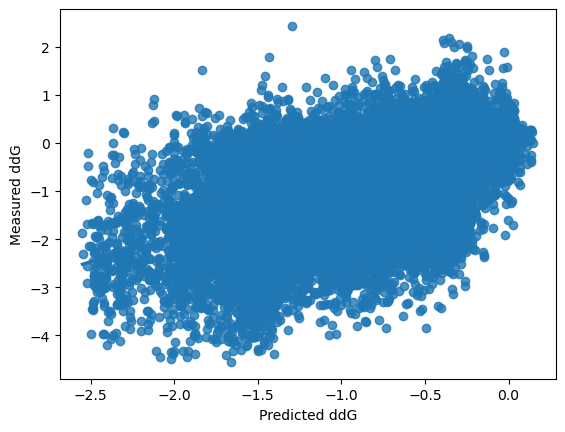

In [11]:
# Define device
device = torch.device("cpu")  # Force CPU

# Move the model to the CPU
lit_model.to(device)

preds = []
all_y = []

for batch in dataloader_val:
    # read from batch
    x = batch["sequence"].to(device)  # Move input tensor to CPU
    mask = batch["mask"].to(device)    # Move mask tensor to CPU
    target = batch["labels"].to(device)  # Move target tensor to CPU

   # print('seq', x.shape)
   # print('mask', mask.shape)
   # print('target', target.shape)

    # Convert input tensor to Double
    x = x.double()

    # predict
    prediction = lit_model(x)

    # Move tensors to CPU and convert to NumPy arrays
    preds.append(prediction[mask == 1].flatten().cpu().detach().numpy())
    all_y.append(target[mask == 1].flatten().cpu().detach().numpy())

# Concatenate and plot
preds = np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds, y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")

# Get RMSE, Pearson, and Spearman correlation

print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))
print("RMSE:", skmetrics.mean_squared_error(all_y, preds,))

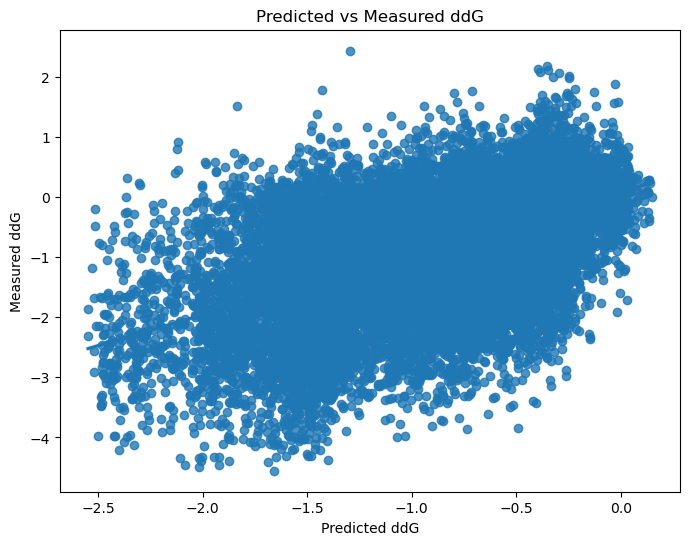

Pearson r: PearsonRResult(statistic=0.5516049579848074, pvalue=0.0)
Spearman r: SignificanceResult(statistic=0.5065515314687057, pvalue=0.0)
RMSE: 0.6004281697214854


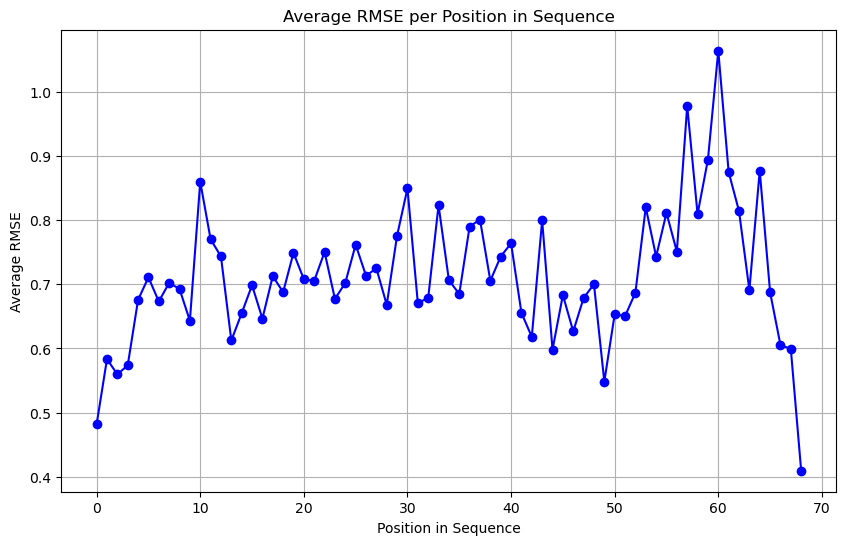

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import sklearn.metrics as skmetrics

# Define device
device = torch.device("cpu")  # Force CPU

# Move the model to the CPU
lit_model.to(device)
lit_model.eval()  # Set the model to evaluation mode

# Initialize lists for predictions and targets
preds = []
all_y = []

# Initialize a list to store RMSE for each position
position_rmse = []

# Validation loop
for batch in dataloader_val:
    # Read from batch
    x = batch["sequence"].to(device)  # Move input tensor to CPU
    mask = batch["mask"].to(device)    # Move mask tensor to CPU
    target = batch["labels"].to(device)  # Move target tensor to CPU

    # Convert input tensor to Double
    x = x.double()

    # Predict
    prediction = lit_model(x)  # Shape: (batch_size, sequence_length, 1)

    # Move tensors to CPU and convert to NumPy arrays
    preds.append(prediction[mask == 1].flatten().cpu().detach().numpy())
    all_y.append(target[mask == 1].flatten().cpu().detach().numpy())

    # Compute RMSE for each position in the sequence
    for pos in range(prediction.shape[1]):  # Iterate over sequence positions
        # Get predictions and targets for the current position
        pred_pos = prediction[:, pos, :]  # Shape: (batch_size, 1)
        target_pos = target[:, pos, :]   # Shape: (batch_size, 1)
        mask_pos = mask[:, pos, :]       # Shape: (batch_size, 1)

        # Compute RMSE only for masked positions
        if mask_pos.sum() > 0:  # Check if there are any valid targets at this position
            rmse_pos = torch.sqrt(torch.mean((pred_pos[mask_pos == 1] - target_pos[mask_pos == 1]) ** 2))
            position_rmse.append((pos, rmse_pos.item()))

# Concatenate predictions and targets
preds = np.concatenate(preds)
all_y = np.concatenate(all_y)

# Plot regression plot
plt.figure(figsize=(8, 6))
sns.regplot(x=preds, y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")
plt.title("Predicted vs Measured ddG")
plt.show()

# Get RMSE, Pearson, and Spearman correlation
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))
print("RMSE:", skmetrics.mean_squared_error(all_y, preds))

# Convert RMSE values to a structured format
position_rmse_dict = {}
for pos, rmse in position_rmse:
    if pos not in position_rmse_dict:
        position_rmse_dict[pos] = []
    position_rmse_dict[pos].append(rmse)

# Compute average RMSE for each position
avg_rmse_per_position = {pos: np.mean(rmses) for pos, rmses in position_rmse_dict.items()}

# Sort positions and get corresponding average RMSE values
sorted_positions = sorted(avg_rmse_per_position.keys())
sorted_avg_rmse = [avg_rmse_per_position[pos] for pos in sorted_positions]

# Plot the average RMSE for each position
plt.figure(figsize=(10, 6))
plt.plot(sorted_positions, sorted_avg_rmse, marker='o', linestyle='-', color='b')
plt.xlabel("Position in Sequence")
plt.ylabel("Average RMSE")
plt.title("Average RMSE per Position in Sequence")
plt.grid(True)
plt.show()

## Interpretation

Try to analyse and interpret your model and/or predictions in the context of the biological question.